In [1]:
!pip install keras-cv

In [2]:
# IMPORT LIBRARIES
# Set seed for reproducibility
seed = 42

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as  tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import keras_cv

from sklearn.model_selection import train_test_split

In [3]:
# LOAD THE DATA & normalize
np.random.seed(seed)
tf.random.set_seed(seed)


data = np.load('/kaggle/input/blood-dataset/training_set.npz') # Load the training data here
X = data['images']
y = data['labels']
X_cleaned = X[:11959]
y_cleaned = y[:11959]

# Normalize images by dividing them by 255.0
X_cleaned = X_cleaned.astype(np.float32) / 255.0

# Flatten each image in a 1D array
X_flattened = X_cleaned.reshape(X_cleaned.shape[0], -1)

# Use numpy.unique to identify unique indexes
_, unique_indices = np.unique(X_flattened, axis=0, return_index=True)

# Filter X and y maintaining only unique elements
X_trimmed = X[unique_indices]
y_trimmed = y[unique_indices]

In [4]:
X2 = data['images']
y2 = data['labels']
X2_cleaned = X2[:11959]
y2_cleaned = y2[:11959]

# Normalize images by dividing them by 255.0
X2_cleaned = X2_cleaned.astype(np.float32)/255.0

# Flatten each image in a 1D array
X2_flattened = X2_cleaned.reshape(X2_cleaned.shape[0], -1)

# Use numpy.unique to identify unique indexes
_, unique_indices = np.unique(X2_flattened, axis=0, return_index=True)

# Filter X2 and y maintaining only unique elements
X2_train = X2[unique_indices]
y2_train = y2[unique_indices]

In [5]:
X3 = data['images']
y3 = data['labels']
X3_cleaned = X3[:11959]
y3_cleaned = y3[:11959]

# Normalize images by dividing them by 255.0
X3_cleaned = X3_cleaned.astype(np.float32)/255.0

# Flatten each image in a 1D array
X3_flattened = X3_cleaned.reshape(X3_cleaned.shape[0], -1)

# Use numpy.unique to identify unique indexes
_, unique_indices = np.unique(X3_flattened, axis=0, return_index=True)

# Filter X2 and y maintaining only unique elements
X3_train = X3[unique_indices]
y3_train = y3[unique_indices]

In [6]:
# INSPECT DATA
print(f"\nOriginal dataset size: {X.shape[0]}")
print(f"Cleaned dataset size: {X_cleaned.shape[0]}")
print(f"Dataset size after removing duplicates: {X_trimmed.shape[0]}")

# Check the shapes and types of the data
print("\nImages shape:", X.shape)  # Expecting (13759, 96, 96, 3)
print("Labels shape:", y.shape)  # Expecting (13759,)

target = y_trimmed
unique, count = np.unique(target, return_counts=True)
for u in unique:
  print(f'Class {unique[u]} has {count[u]} samples')

print("Target shape:", target.shape)


Original dataset size: 13759
Cleaned dataset size: 11959
Dataset size after removing duplicates: 11951

Images shape: (13759, 96, 96, 3)
Labels shape: (13759, 1)
Class 0 has 850 samples
Class 1 has 2179 samples
Class 2 has 1085 samples
Class 3 has 2023 samples
Class 4 has 849 samples
Class 5 has 992 samples
Class 6 has 2330 samples
Class 7 has 1643 samples
Target shape: (11951, 1)


In [7]:
y_trimmed = tfk.utils.to_categorical(y_trimmed, num_classes=8)
y2_train = tfk.utils.to_categorical(y2_train, num_classes=8)
y3_train = tfk.utils.to_categorical(y2_train, num_classes=8)

# Split data into train and val_test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_trimmed, y_trimmed, random_state=seed, test_size=0.4, stratify=np.argmax(y_trimmed,axis=1))

In [8]:
#PRE PROCESSING

def preprocess(X_train, y_train):
    
    # Apply CutMix together with normalization
    def preprocess_cutmix(image, label):
        #image = tf.keras.applications.convnext.preprocess_input(image)
        #image = tf.cast(image, dtype=tf.float32) / 255.0
        augmented = cutmix({"images": image, "labels": label})
        image, label = augmented["images"], augmented["labels"]
        return image, label

    # Apply CutOut together with normalization
    def preprocess_cutout(image, label):
        #image = tf.keras.applications.convnext.preprocess_input(image)
        #image = tf.cast(image, dtype=tf.float32) / 255.0
        augmented = cutout({"images": image, "labels": label})
        image, label = augmented["images"], augmented["labels"]
        return image, label
    
    y_train = y_train.astype(np.float32)
    batch_size = 32

    # Create different sets of X and y
    X_mix, X_cut, y_mix, y_cut = train_test_split(X_train, y_train, random_state=seed, test_size=0.5, stratify=np.argmax(y_train,axis=1))
    
    mix_dataset = tf.data.Dataset.from_tensor_slices((X_mix, y_mix))
    cut_dataset = tf.data.Dataset.from_tensor_slices((X_cut, y_cut))
    
    # Create the cutmix function
    cutmix = keras_cv.layers.CutMix(alpha=0.5)

    # Create the cutout function
    cutout = keras_cv.layers.RandomCutout(
        height_factor=0.3, 
        width_factor=0.3,
        fill_mode="constant"
    )
    
    #Apply the augmentation functions on the datasets
    mix_dataset = (
        mix_dataset
        .batch(batch_size)
        .map(preprocess_cutmix, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE) 
    )
    cut_dataset = (
        cut_dataset
        .batch(batch_size)
        .map(preprocess_cutout, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE) 
    )
    new_dataset = mix_dataset.concatenate(cut_dataset)
    
    X_train = []
    y_train = []
  
    # Itera su tutto il dataset
    for images, labels in new_dataset:
        X_train.append(images.numpy())
        y_train.append(labels.numpy())

    # Concatena i batch in array completi
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    return X_train,y_train  

In [9]:
#PRE PROCESSING WITH AUGMENTATION

def preprocess_augm(X_train, y_train):
    
    # Apply RandAugment together with normalization
    def preprocess_with_augmentation(image, label):
        #image = tf.keras.applications.convnext.preprocess_input(image)
        #image = tf.cast(image, dtype=tf.float32) / 255.0
        augmented_image = data_augmentation({"images": image})["images"]
        return augmented_image, label

    # Apply an augmentation pipeline together with normalization
    def preprocess_pipe(image, label):
        #image = tf.keras.applications.convnext.preprocess_input(image)
        #image = tf.cast(image, dtype=tf.float32) / 255.0
        augmented = pipeline({"images": image})["images"]
        return augmented, label
        
    
    y_train = y_train.astype(np.float32)
    batch_size = 32
    image_layer = 3;

    # Create different sets of X and y
    X_pipe, X_rand, y_pipe, y_rand = train_test_split(X_train, y_train, random_state=seed, test_size=0.5, stratify=np.argmax(y_train,axis=1))
    
    rand_dataset = tf.data.Dataset.from_tensor_slices((X_rand, y_rand))
    pipe_dataset = tf.data.Dataset.from_tensor_slices((X_pipe, y_pipe))
     
    # Create the data augmentation function
    data_augmentation = keras_cv.layers.RandAugment(
        value_range=(0.0, 255.0),
        augmentations_per_image=4,
        magnitude=0.4,
        rate=0.7
    )
    
    # Create the gaussian noise function
    pipeline = keras_cv.layers.RandomAugmentationPipeline(
        layers=[
            keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
            keras_cv.layers.RandomContrast(factor=0.3, value_range=(0.0, 255.0), seed=seed),
            keras_cv.layers.RandomHue(factor=(0.5, 0.5), value_range=(0.0, 255.0), seed=seed),
            keras_cv.layers.RandomSharpness(factor=(0.5, 0.5), value_range=(0.0, 255.0), seed=seed),
            keras_cv.layers.RandomColorDegeneration(factor=(0.5, 0.5), seed=seed),
            keras_cv.layers.RandomChannelShift(factor=0.5, value_range=(0.0, 255.0), channels=3, seed=seed),
            keras_cv.layers.Solarization(value_range=(0.0, 255.0), seed=seed),
            keras_cv.layers.RandomBrightness(factor=0.3, value_range=(0.0, 255.0), seed=seed),
        ],
        seed=7,
        augmentations_per_image=4
    )

    #Apply the augmentation functions on the datasets
    rand_dataset = (
        rand_dataset
        .batch(batch_size)
        .map(preprocess_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE) 
    )
    pipe_dataset = (
        pipe_dataset
        .batch(batch_size)
        .map(preprocess_pipe, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE) 
    )
    new_dataset = rand_dataset.concatenate(pipe_dataset)

    X_train = []
    y_train = []
  
    # Itera su tutto il dataset
    for images, labels in new_dataset:
        X_train.append(images.numpy())
        y_train.append(labels.numpy())

    # Concatena i batch in array completi
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    return X_train,y_train  

In [10]:
#cut mix and cutout for 60% of dataset1
X_train,y_train=preprocess(X_train,y_train)

#augmentation for 40% of dataset1
X_val_test,y_val_test=preprocess_augm(X_val_test,y_val_test)

#randaugm + pipeline for dataset2
X2_train,y2_train=preprocess_augm(X2_train,y2_train)

# Concatenate all the training set
X_train = np.concatenate((X_train, X2_train), axis=0)
y_train = np.concatenate((y_train, y2_train), axis=0)

# Shuffle data plit data into train and val_test sets
indices = np.arange(len(X_val_test))
np.random.shuffle(indices)
X_val_test = X_val_test[indices]
y_val_test = y_val_test[indices]
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, random_state=seed, test_size=0.5, stratify=np.argmax(y_val_test,axis=1))

# Shuffle data in the training set
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (19121, 96, 96, 3), y_train shape: (19121, 8)
X_val shape: (2390, 96, 96, 3), y_val shape: (2390, 8)
X_test shape: (2391, 96, 96, 3), y_test shape: (2391, 8)


In [11]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

# Batch size for training
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("\nBatch Size:", batch_size)
print("Learning Rate:", learning_rate)

Input Shape: (96, 96, 3)
Output Shape: 8

Batch Size: 64
Learning Rate: 0.001


In [12]:
# Initialise ConvNeXtBase model with pretrained weights, for transfer learning
convnext = tfk.applications.ConvNeXtBase(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling=None,
)

# Display a summary of the model architecture
convnext.summary(expand_nested=True)

# Freeze all layers in ConvNeXtBase to use it solely as a feature extractor
convnext.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Pass augmented inputs through the ConvNeXt feature extractor
x = convnext(inputs)

# Add a GAP layer
x = tfkl.GlobalAveragePooling2D(name='global_average_pooling')(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4), metrics=['accuracy'])

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "convnext_base"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_pres… │ (None, 96, 96, 3) │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stem  │ (None, 24, 24,    │      6,528 │ convnext_base_pr… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 24, 24,    │      6,272 │ -                 │
│ convnext_base_stem… │ 128)              │            │                   │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 24, 24,    │        256 │ -                 │
│ convnext_base_stem… │ 128)              │            │                   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │      6,400 │ convnext_base_st… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │        128 │ convnext_base_st… │
│ (LayerScale)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │          0 │ convnext_base_st… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ convnext_base_st… │
│                     │ 128)              │            │ convnext_base_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │      6,400 │ add[0][0]         │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                 

 Total params: 87,566,464 (334.04 MB)

 Trainable params: 87,566,464 (334.04 MB)

 Non-trainable params: 0 (0.00 B)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 3, 3, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer (InputLayer)   │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 96, 96, 3)      │             0 │
│ convnext_base_prestem_normaliz… │                        │               │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ convnext_base_stem         │ (None, 24, 24, 128)    │         6,528 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ convnext_base_stem_conv │ (None, 24, 24, 128)    │         6,272 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └                         │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stem_layernorm    │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,400 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │        66,048 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │        65,664 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           128 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerScale)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,40

 Total params: 87,574,664 (334.07 MB)

 Trainable params: 8,200 (32.03 KB)

 Non-trainable params: 87,566,464 (334.04 MB)

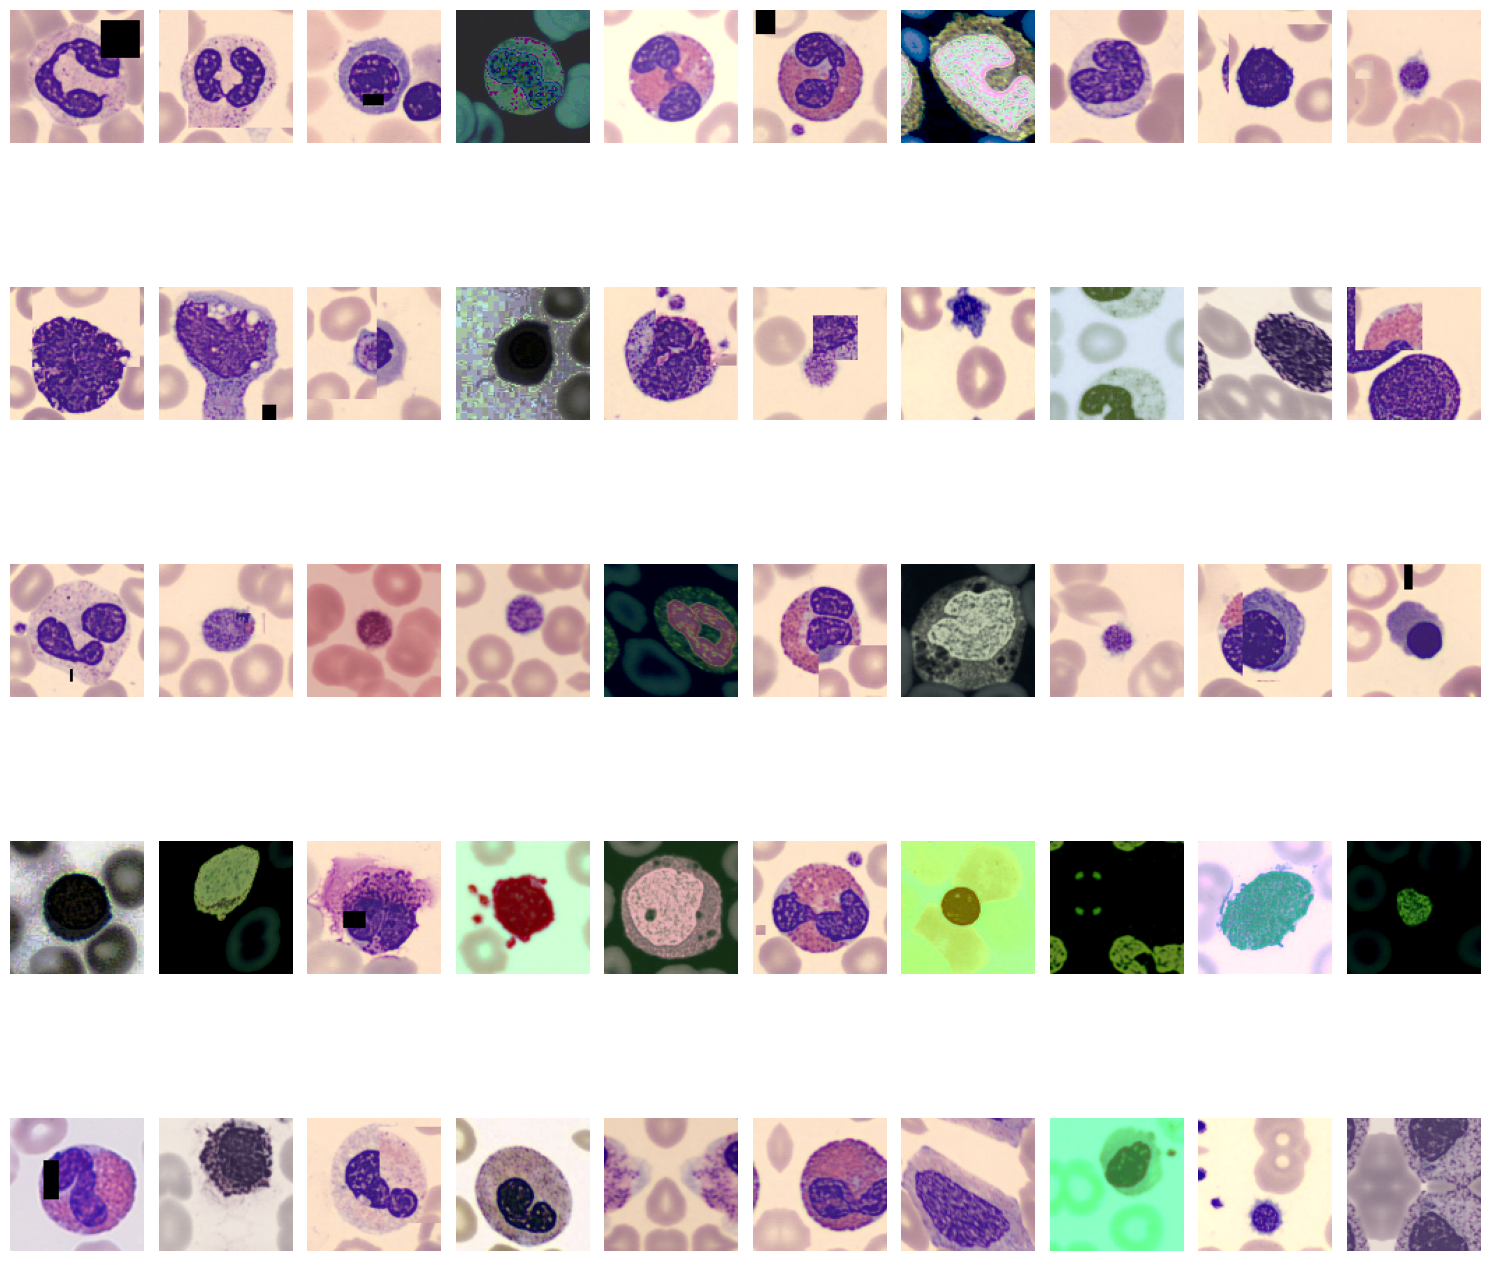

In [13]:
# Calcola il layout della griglia
rows = 5
cols = 10

# Mostra le immagini
plt.figure(figsize=(15, rows * 3))  # Regola la dimensione della figura
for i in range(50):
    plt.subplot(rows, cols, i + 1)  # Layout dinamico
    plt.imshow(X_train[i].astype("uint8"))  # Mostra l'immagine
    plt.axis("off")  # Rimuovi gli assi
plt.tight_layout()  # Aggiusta gli spazi tra i subplot
plt.show()

In [14]:
# Train the model
tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'CNN_'+str(final_val_accuracy)+'.keras'
tl_model.save('weights.keras')

# Free memory by deleting the model instance
del tl_model

Epoch 1/10


I0000 00:00:1732460114.050969     100 service.cc:145] XLA service 0x7ab8c40555e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732460114.051051     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/299 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.2461 - loss: 2.3862   

I0000 00:00:1732460121.447629     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


299/299 ━━━━━━━━━━━━━━━━━━━━ 62s 135ms/step - accuracy: 0.5249 - loss: 1.3892 - val_accuracy: 0.7820 - val_loss: 0.6635
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.7599 - loss: 0.7757 - val_accuracy: 0.8280 - val_loss: 0.5605
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.7889 - loss: 0.6819 - val_accuracy: 0.8351 - val_loss: 0.5182
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.8036 - loss: 0.6489 - val_accuracy: 0.8452 - val_loss: 0.4947
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.8133 - loss: 0.6264 - val_accuracy: 0.8498 - val_loss: 0.4797
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - accuracy: 0.8159 - loss: 0.6168 - val_accuracy: 0.8494 - val_loss: 0.4731
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.8167 - loss: 0.6064 - val_accuracy: 0.8523 - val_loss: 0.4633
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - accuracy: 0.8155 - loss: 0.6015 - val_accura

In [15]:
# Load the saved model
model = tfk.models.load_model('weights.keras')
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (2391, 8)


Accuracy score over the test set: 0.8453
Precision score over the test set: 0.8473
Recall score over the test set: 0.8453
F1 score over the test set: 0.8453


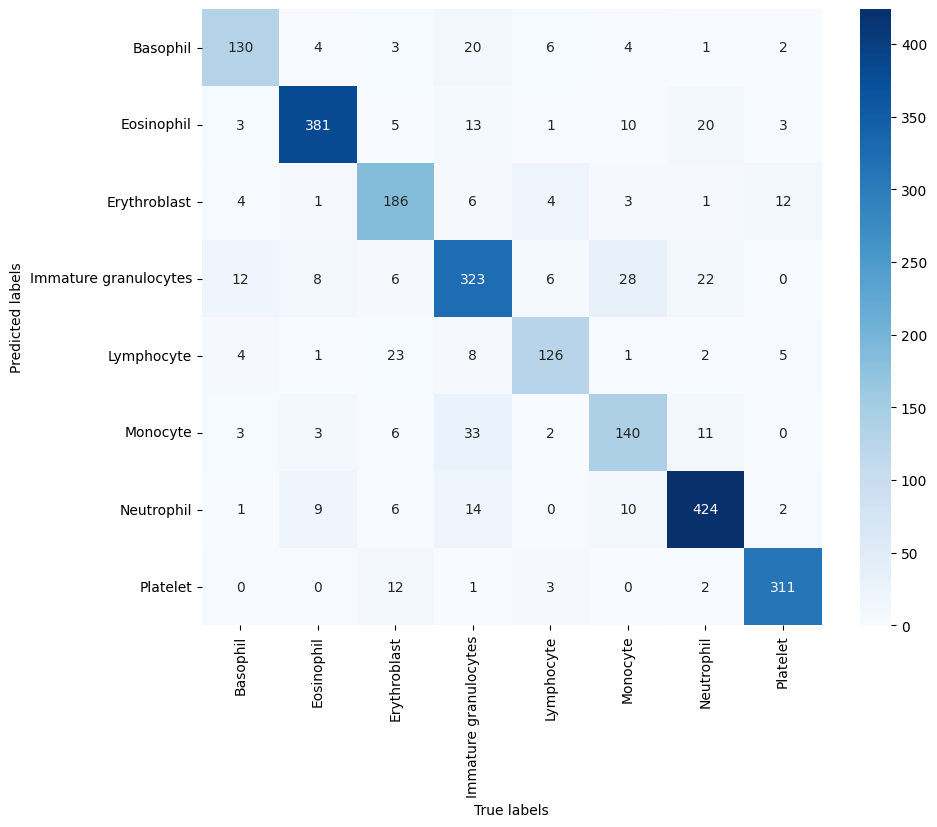

In [16]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)
labels = {0: 'Basophil', 1: 'Eosinophil', 2: 'Erythroblast', 3: 'Immature granulocytes', 4:'Lymphocyte', 5: 'Monocyte', 6: 'Neutrophil', 7: 'Platelet'}
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

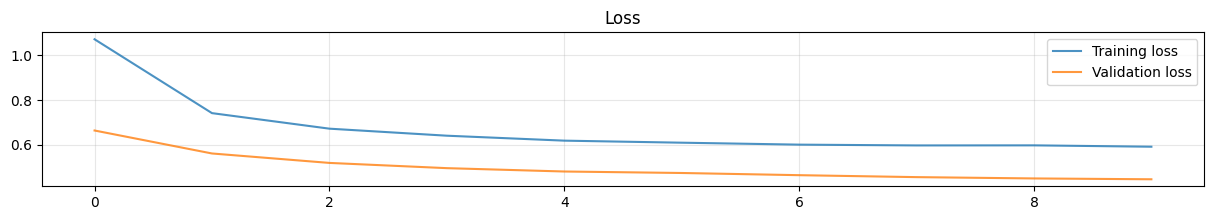

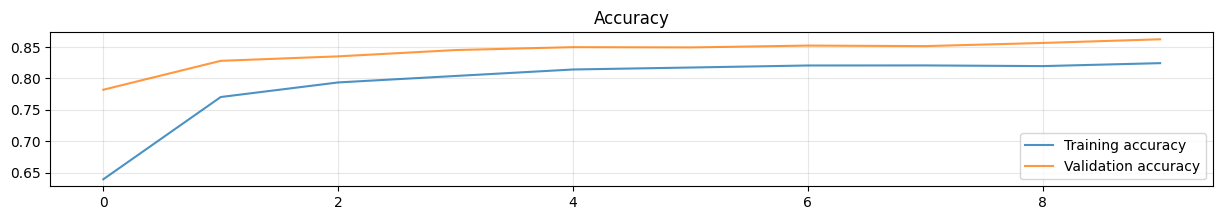

In [17]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(tl_history['loss'], label='Training loss', alpha=.8)
plt.plot(tl_history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(tl_history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [18]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('weights.keras')

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

# Set the ConvNeXtBase model layers as trainable
ft_model.get_layer('convnext_base').trainable = True

# Set all ConvNeXtBase layers as non-trainable
for layer in ft_model.get_layer('convnext_base').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

# Set the number of layers to freeze
N = 150

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 3, 3, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer (InputLayer)   │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 96, 96, 3)      │             0 │
│ convnext_base_prestem_normaliz… │                        │               │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ convnext_base_stem         │ (None, 24, 24, 128)    │         6,528 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ convnext_base_stem_conv │ (None, 24, 24, 128)    │         6,272 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └                         │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stem_layernorm    │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,400 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │        66,048 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │        65,664 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           128 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerScale)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,40

 Total params: 87,591,066 (334.13 MB)

 Trainable params: 8,200 (32.03 KB)

 Non-trainable params: 87,566,464 (334.04 MB)

 Optimizer params: 16,402 (64.07 KB)

3 convnext_base_stage_0_block_0_depthwise_conv Conv2D True
10 convnext_base_stage_0_block_1_depthwise_conv Conv2D True
17 convnext_base_stage_0_block_2_depthwise_conv Conv2D True
25 convnext_base_stage_1_block_0_depthwise_conv Conv2D True
32 convnext_base_stage_1_block_1_depthwise_conv Conv2D True
39 convnext_base_stage_1_block_2_depthwise_conv Conv2D True
47 convnext_base_stage_2_block_0_depthwise_conv Conv2D True
54 convnext_base_stage_2_block_1_depthwise_conv Conv2D True
61 convnext_base_stage_2_block_2_depthwise_conv Conv2D True
68 convnext_base_stage_2_block_3_depthwise_conv Conv2D True
75 convnext_base_stage_2_block_4_depthwise_conv Conv2D True
82 convnext_base_stage_2_block_5_depthwise_conv Conv2D True
89 convnext_base_stage_2_block_6_depthwise_conv Conv2D True
96 convnext_base_stage_2_block_7_depthwise_conv Conv2D True
103 convnext_base_stage_2_block_8_depthwise_conv Conv2D True
110 convnext_base_stage_2_block_9_depthwise_conv Conv2D True
117 convnext_base_stage_2_block_10_dept

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 3, 3, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer (InputLayer)   │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 96, 96, 3)      │             0 │
│ convnext_base_prestem_normaliz… │                        │               │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ convnext_base_stem         │ (None, 24, 24, 128)    │         6,528 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ convnext_base_stem_conv │ (None, 24, 24, 128)    │         6,272 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └                         │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stem_layernorm    │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,400 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │        66,048 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │        65,664 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           128 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerScale)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,40

 Total params: 87,591,066 (334.13 MB)

 Trainable params: 469,000 (1.79 MB)

 Non-trainable params: 87,105,664 (332.28 MB)

 Optimizer params: 16,402 (64.07 KB)

In [19]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=1500,
)), metrics=['accuracy'])

Epoch 1/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 85s 99ms/step - accuracy: 0.8427 - loss: 0.5480 - val_accuracy: 0.8774 - val_loss: 0.3718
Epoch 2/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - accuracy: 0.8611 - loss: 0.4876 - val_accuracy: 0.8824 - val_loss: 0.3577
Epoch 3/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.8690 - loss: 0.4685 - val_accuracy: 0.8845 - val_loss: 0.3477
Epoch 4/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.8726 - loss: 0.4522 - val_accuracy: 0.8900 - val_loss: 0.3300
Epoch 5/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.8870 - loss: 0.4131 - val_accuracy: 0.8908 - val_loss: 0.3214
Epoch 6/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.8926 - loss: 0.3915 - val_accuracy: 0.8925 - val_loss: 0.3169
Epoch 7/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.8963 - loss: 0.3825 - val_accuracy: 0.8929 - val_loss: 0.3169
Epoch 8/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - accuracy: 0.9007 - loss: 0.3786 - 

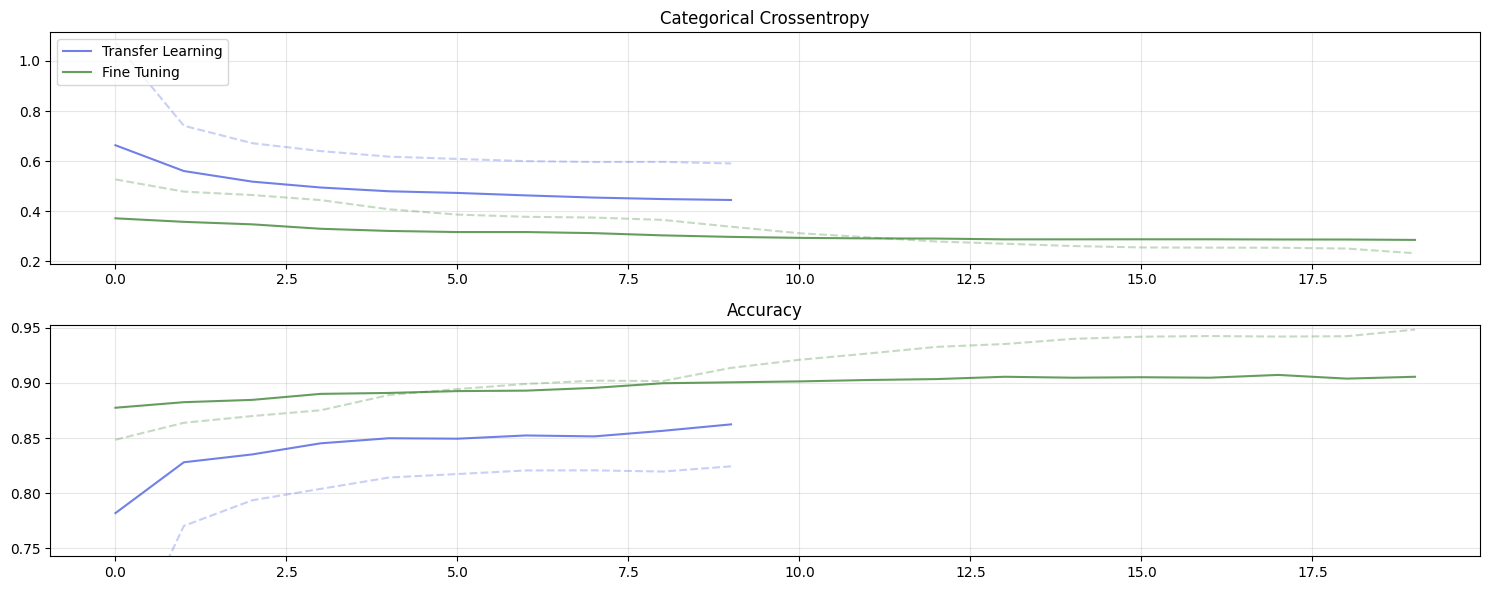

In [20]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    epochs = 20,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(tl_history['val_accuracy']) * 0.95, max(ft_history['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

In [21]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [22]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip -r {filename} model.py weights.keras

print(f"{filename} creato")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 8%)
submission_241124_151644.zip creato
